In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap


def waffle_plot(
    categories,
    values,
    width=10,
    height=10,
    cmap=plt.cm.viridis,
    c=None,
    bc="w",
    autoscale=True,
    over_represent=False,
    vertical=True,
    label_v=True,
    label_p=False,
    legend_ncols=1,
    legend_loc=(1.35, 0.685),
    figsize=(6.4, 4.8),
    value_sign="",
    font="DejaVu Sans",
    fontsize=10,
    font_c="black",
    save=None,
):

    """
    Makes a waffle plot, a customized matshow plot that represents
    the proportions of different categories.
    Parameters:
    ----------
    categories: array-like
        A collection of categories.
    values: array-like
        A collection of values corresponding to the categories.
    width : int, default: 10
        The width of the waffle plot in number of tiles.
    height : int, default: 10
        The height of the waffle plot in number of tiles.
    cmap : matplotlib colormap, default: plt.cm.viridis
        The colormap to use for generating colors for the categories.
    c : array-like or list of colors or color, optional
        Possible values:
        - A scalar or sequence of n numbers to be mapped to colors
        - A 2D array in which the rows are RGB or RGBA.
        - A sequence of colors of length n.
        - A single color format string.
        A collection of colors to be used for the tiles of the different
        categories. If not provided, colors will be generated from the cmap.
        If 'c' is shorter then 'categories', the missing colors will be
        taken from cmap.
    bc : str, default: 'white'
        The background color of the plot and the grid.
    autoscale : bool, default: True
        Whether to adjust the width and height of the plot to ensure that
        all categories are represented by at least one tile. If autoscale
        is True, the number of patches will grow until it can accomodate
        the smallest non-zero value from values.
    over_represent : bool, default: False
        Whether to over-represent the proportions by using extra tiles for
        the same category. If the smallest category has one tile and fills
        less than 50% of it, if over_represent is True, the tile will still
        have the category color. If over_represent is False, the tile will
        adopt the color of the background.
    vertical : bool, default: True
        Whether to stack the tiles vertically (True) or horizontally (False).
    label_v : bool, default: True
        Whether to label the tiles with the corresponding values.
        When True, it add value in brackets to the legend.
    label_p : bool, default: False
        Whether to label the tiles with the corresponding proportions.
        When True, the function calculates the percentage of the value and
        adds it in brackets to the legend. When both label_v and label_p
        are True, it will add both, value after colon and percentage
        in brackets.
    legend_ncols : int, default: 1
        The number of columns to use in the legend.
        To make flat horizontal Legend, it should equal the number
        of categories.
    legend_loc : tuple, default: (1.35, 0.695)
        The location of the legend as a tuple of x and y coordinates.
    figsize : tuple, default: (6.4, 4.8)
        The size of the figure as a tuple of width and height in inches.
    value_sign : str, default: ''
        A string to be used as a suffix for the value in the legend.
    font : str, default: 'DejaVu Sans'
        The font to be used for the labels in the legend.
    font_c : str, default: 'black'
        The color of the font to be used for the labels in the legend.
    save : str, optional
        The file name and path to save the plot to. If None, plt.show()
        is used instead.
    Returns:
    -------
    matplotlib.figure.Figure
        The figure object of the waffle plot.
    """

    # Instantiate Waffle class with arguments from the function
    waffle = Waffle(
        categories,
        values,
        width,
        height,
        cmap,
        c,
        bc,
        autoscale,
        over_represent,
        vertical,
        label_v,
        label_p,
        legend_ncols,
        legend_loc,
        figsize,
        value_sign,
        font,
        fontsize,
        font_c,
        save,
    )

    # Create waffle attributes - an array and its' features
    waffle.create_array()

    # Map colormap and colors attributes for the waffle plot and it's legend
    waffle.map_colors()

    # Prepare the legend handles (strings and colors) for the waffle
    waffle.prepare_legend_handles()

    # Plot the waffle
    waffle.plot()


class Waffle:

    """
    Creates a waffle object.
    """

    def __init__(
        self,
        categories,
        values,
        width,
        height,
        cmap,
        c,
        bc,
        autoscale,
        over_represent,
        vertical,
        label_v,
        label_p,
        legend_ncols,
        legend_loc,
        figsize,
        value_sign,
        font,
        fontsize,
        font_c,
        save,
    ):

        self.categories = categories
        self.values = values
        self.width = width
        self.height = height
        self.cmap = cmap
        self.c = c
        self.bc = bc
        self.autoscale = autoscale
        self.over_represent = over_represent
        self.vertical = vertical
        self.label_v = label_v
        self.label_p = label_p
        self.legend_ncols = legend_ncols
        self.legend_loc = legend_loc
        self.figsize = figsize
        self.value_sign = value_sign
        self.font = font
        self.fontsize = fontsize
        self.font_c = font_c
        self.save = save

    def create_array(self):

        """
        Creates an array attribute and it's features for the waffle.
        """

        # Getting sorted categories and values
        self.categories, self.values = zip(
            *sorted(zip(self.categories, self.values), key=lambda x: x[1], reverse=True)
        )

        self.values_non_zero = len([val for val in self.values if val > 0])
        self.proportions_non_zero = [
            (float(v) / sum(self.values)) for v in self.values if v > 0
        ]

        # autoscaling_done - a condition variable for 'while' loop for auto-scaling
        autoscaling_done = False

        while autoscaling_done is False:

            total = self.width * self.height

            tiles_per_category = [
                round(proportion * total) for proportion in self.proportions_non_zero
            ]

            # Make a dummy matrix for use in plotting.
            self.array = [
                [0 for col in range(self.width)] for row in range(self.height)
            ]

            # Popoulate the dummy matrix with integer values.
            category_index = 0
            tile_index = 0

            if self.vertical:
                x = self.width  # i is a row
                y = self.height  # j is a col
            else:
                x = self.height  # i is a col
                y = self.width  # j is a row

            # Iterate over each tile.
            for i in range(x):
                for j in range(y):
                    tile_index += 1

                    # If the number of tiles populated is sufficient for
                    # this category...
                    if tile_index > sum(tiles_per_category[0:category_index]):
                        # ...increment to the next category.
                        category_index += 1

                    # Set the category value to an integer, which increases
                    # with category.
                    if self.vertical:
                        self.array[j][i] = category_index
                    else:
                        self.array[i][j] = category_index

            if len(set([item for sublist in self.array for item in sublist])) < len(
                self.proportions_non_zero
            ):

                if self.autoscale:
                    autoscaling_done = False
                    self.width += 1
                    self.height += 1
                else:
                    autoscaling_done = True
            else:
                autoscaling_done = True

        if self.autoscale is False:
            # If number of unique values in waffle is smaller than number of bins,
            # reduce number of bins

            if (
                len(set([i for sublist in self.array for i in sublist]))
                < self.values_non_zero
            ):
                self.values_non_zero = len(
                    set([i for sublist in self.array for i in sublist])
                )

        if any(self.values) > 0:

            # Compute the portion of the total assigned to each category.
            self.proportions = [(value / sum(self.values)) for value in self.values]

        else:
            self.proportions = [
                1 for v in self.values
            ]  # Just so it does not throw an error

        return (
            self.array,
            self.height,
            self.width,
            self.proportions,
            self.values_non_zero,
            self.proportions_non_zero,
        )

    def map_colors(self):

        """
        Maps colormap and colors attributes for the waffle plot and it's legend.
        """

        # Getting number of categories

        self.cmap = self.cmap.resampled(len(self.categories))

        # Getting number of bins. We don't need bins for empty (== 0) categories,
        # we are only counting non-zero values

        if self.c is None:

            self.c = [self.cmap(x) for x in range(len(self.categories))]

        else:
            # If there are fewer colors than categories...
            if len(self.c) < len(self.categories):
                # Extend list c with appropriate number of colors from colormap
                self.c.extend(
                    [self.cmap(x) for x in range(len(self.categories))][len(self.c) :]
                )

            elif len(self.c) > len(self.categories):
                # Cutting color list in case we have more colors than categories
                self.c = self.c[: len(self.categories)]

        # Instead of 'c', using special version 'c_for_cmap', that is cut at
        # the length equal to number of bins

        self.c_for_cmap = self.c[: self.values_non_zero]

        if not self.over_represent and len(self.c_for_cmap) == len(
            [val for val in self.values if val > 0]
        ):
            for i in self.proportions_non_zero:
                if i < 0.5 * (1 / (self.height * self.width)):
                    self.c_for_cmap[-1] = self.bc

        if any(self.values) > 0:

            # Constructing colormap
            cmap_name = "the_cmap"
            self.cmap = LinearSegmentedColormap.from_list(
                cmap_name, self.c_for_cmap, N=self.values_non_zero
            )

        return self.cmap, self.c, self.c_for_cmap

    def prepare_legend_handles(self):

        """
        Prepares the legend handles for the waffle.
        """

        # variables for the legend
        values_cumsum = [sum(self.values[: i + 1]) for i in range(len(self.values))]
        total_values = values_cumsum[len(values_cumsum) - 1]

        # Empty list, that will be filled with legend handles
        self.legend_handles = []

        # Constructing the legend. Depending on the controls, it can have:
        for i, (category, color) in enumerate(zip(self.categories, self.c)):
            if (
                self.label_v and not self.label_p
            ):  # Values only, with the sign or without it
                if self.value_sign == "%":
                    label_str = f"{category} ({self.values[i]}{self.value_sign})"
                else:
                    label_str = f"{category} ({self.value_sign}{self.values[i]})"

            elif (
                self.label_v and self.label_p
            ):  # Values and percentages calculated automatically
                if self.value_sign == "%":
                    label_str = f"{category}: {self.values[i]}{self.value_sign} ({self.proportions[i] * 100:.2f}%)"
                else:
                    label_str = f"{category}: {self.value_sign}{self.values[i]} ({self.proportions[i] * 100:.2f}%)"

            elif (
                not self.label_v and self.label_p
            ):  # only percentages calculated automatically
                label_str = f"{category} ({self.proportions[i] * 100:.2f}%)"

            if not self.label_v and not self.label_p:  # The name of the category only
                label_str = f"{category}"

            self.legend_handles.append(mpatches.Patch(color=self.c[i], label=label_str))

        return self.legend_handles

    def plot(self):

        """
        Plots the waffle.
        """

        # Grid line auto-adjustment
        if self.height < 25 and self.width < 25:
            linewidth = 1
        else:
            linewidth = 0.5

        # Create a new figure and ax
        fig, ax = plt.subplots(figsize=self.figsize, facecolor=self.bc)

        if len(self.c_for_cmap) > 1:
            # Visualisng the waffle array as waffle plot
            ax.matshow(self.array, cmap=self.cmap)
        else:
            # Visualisng the waffle array as waffle plot, only transparent
            ax.matshow(self.array, alpha=0)

        # With color control, to not get an empty plot for only one not empty
        # category, a facecolor has to be set. Same for the special case of
        # empty waffle.

        if len(self.c_for_cmap) < 1:
            ax.set_facecolor("lightgrey")
        elif len(self.c_for_cmap) < 2:
            ax.set_facecolor(self.c[0])

        # Minor ticks
        ax.set_xticks([x - 0.5 for x in range(self.width)], minor=True)
        ax.set_yticks([x - 0.5 for x in range(self.height)], minor=True)

        # Switch the sticking out ticks off (by setting length to 0):
        ax.tick_params(axis="both", which="both", length=0)

        # Gridlines based on minor ticks
        ax.grid(which="minor", color=self.bc, linestyle="-", linewidth=linewidth)

        # Switch off the numbers associated with ticks
        plt.xticks([])
        plt.yticks([])

        # Add the legend
        l = ax.legend(
            handles=self.legend_handles,
            loc="lower center",
            ncol=self.legend_ncols,
            labelcolor=self.font_c,
            bbox_to_anchor=self.legend_loc,
        )

        # Font controls for the legend
        plt.setp(l.texts, family=self.font, fontsize=self.fontsize)

        # Option to save an image
        if self.save is not None:
            plt.savefig(self.save, bbox_inches="tight", dpi=300)

        else:
            plt.show()

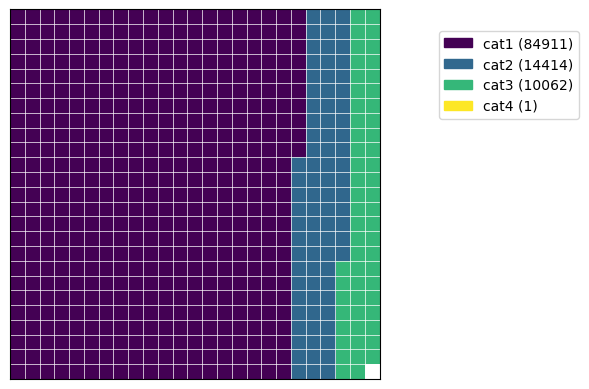

In [12]:
import pandas as pd
import matplotlib.pyplot as plt # for non-default colormaps

# plt.figure(
#     FigureClass=Waffle,
#     rows=500,
#     columns=500,
#     values={'Cat1': 30, 'Cat2': 16, 'Cat3': 4},
#     legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)}
# )

import pandas as pd
import matplotlib.pyplot as plt # for non-default colormaps

df1 = pd.DataFrame({ 'categories': ['cat1', 'cat2', 'cat3', 'cat4'],
                    'values': [84911, 14414, 10062, 1] })

waffle_plot(df1['categories'], df1['values'])


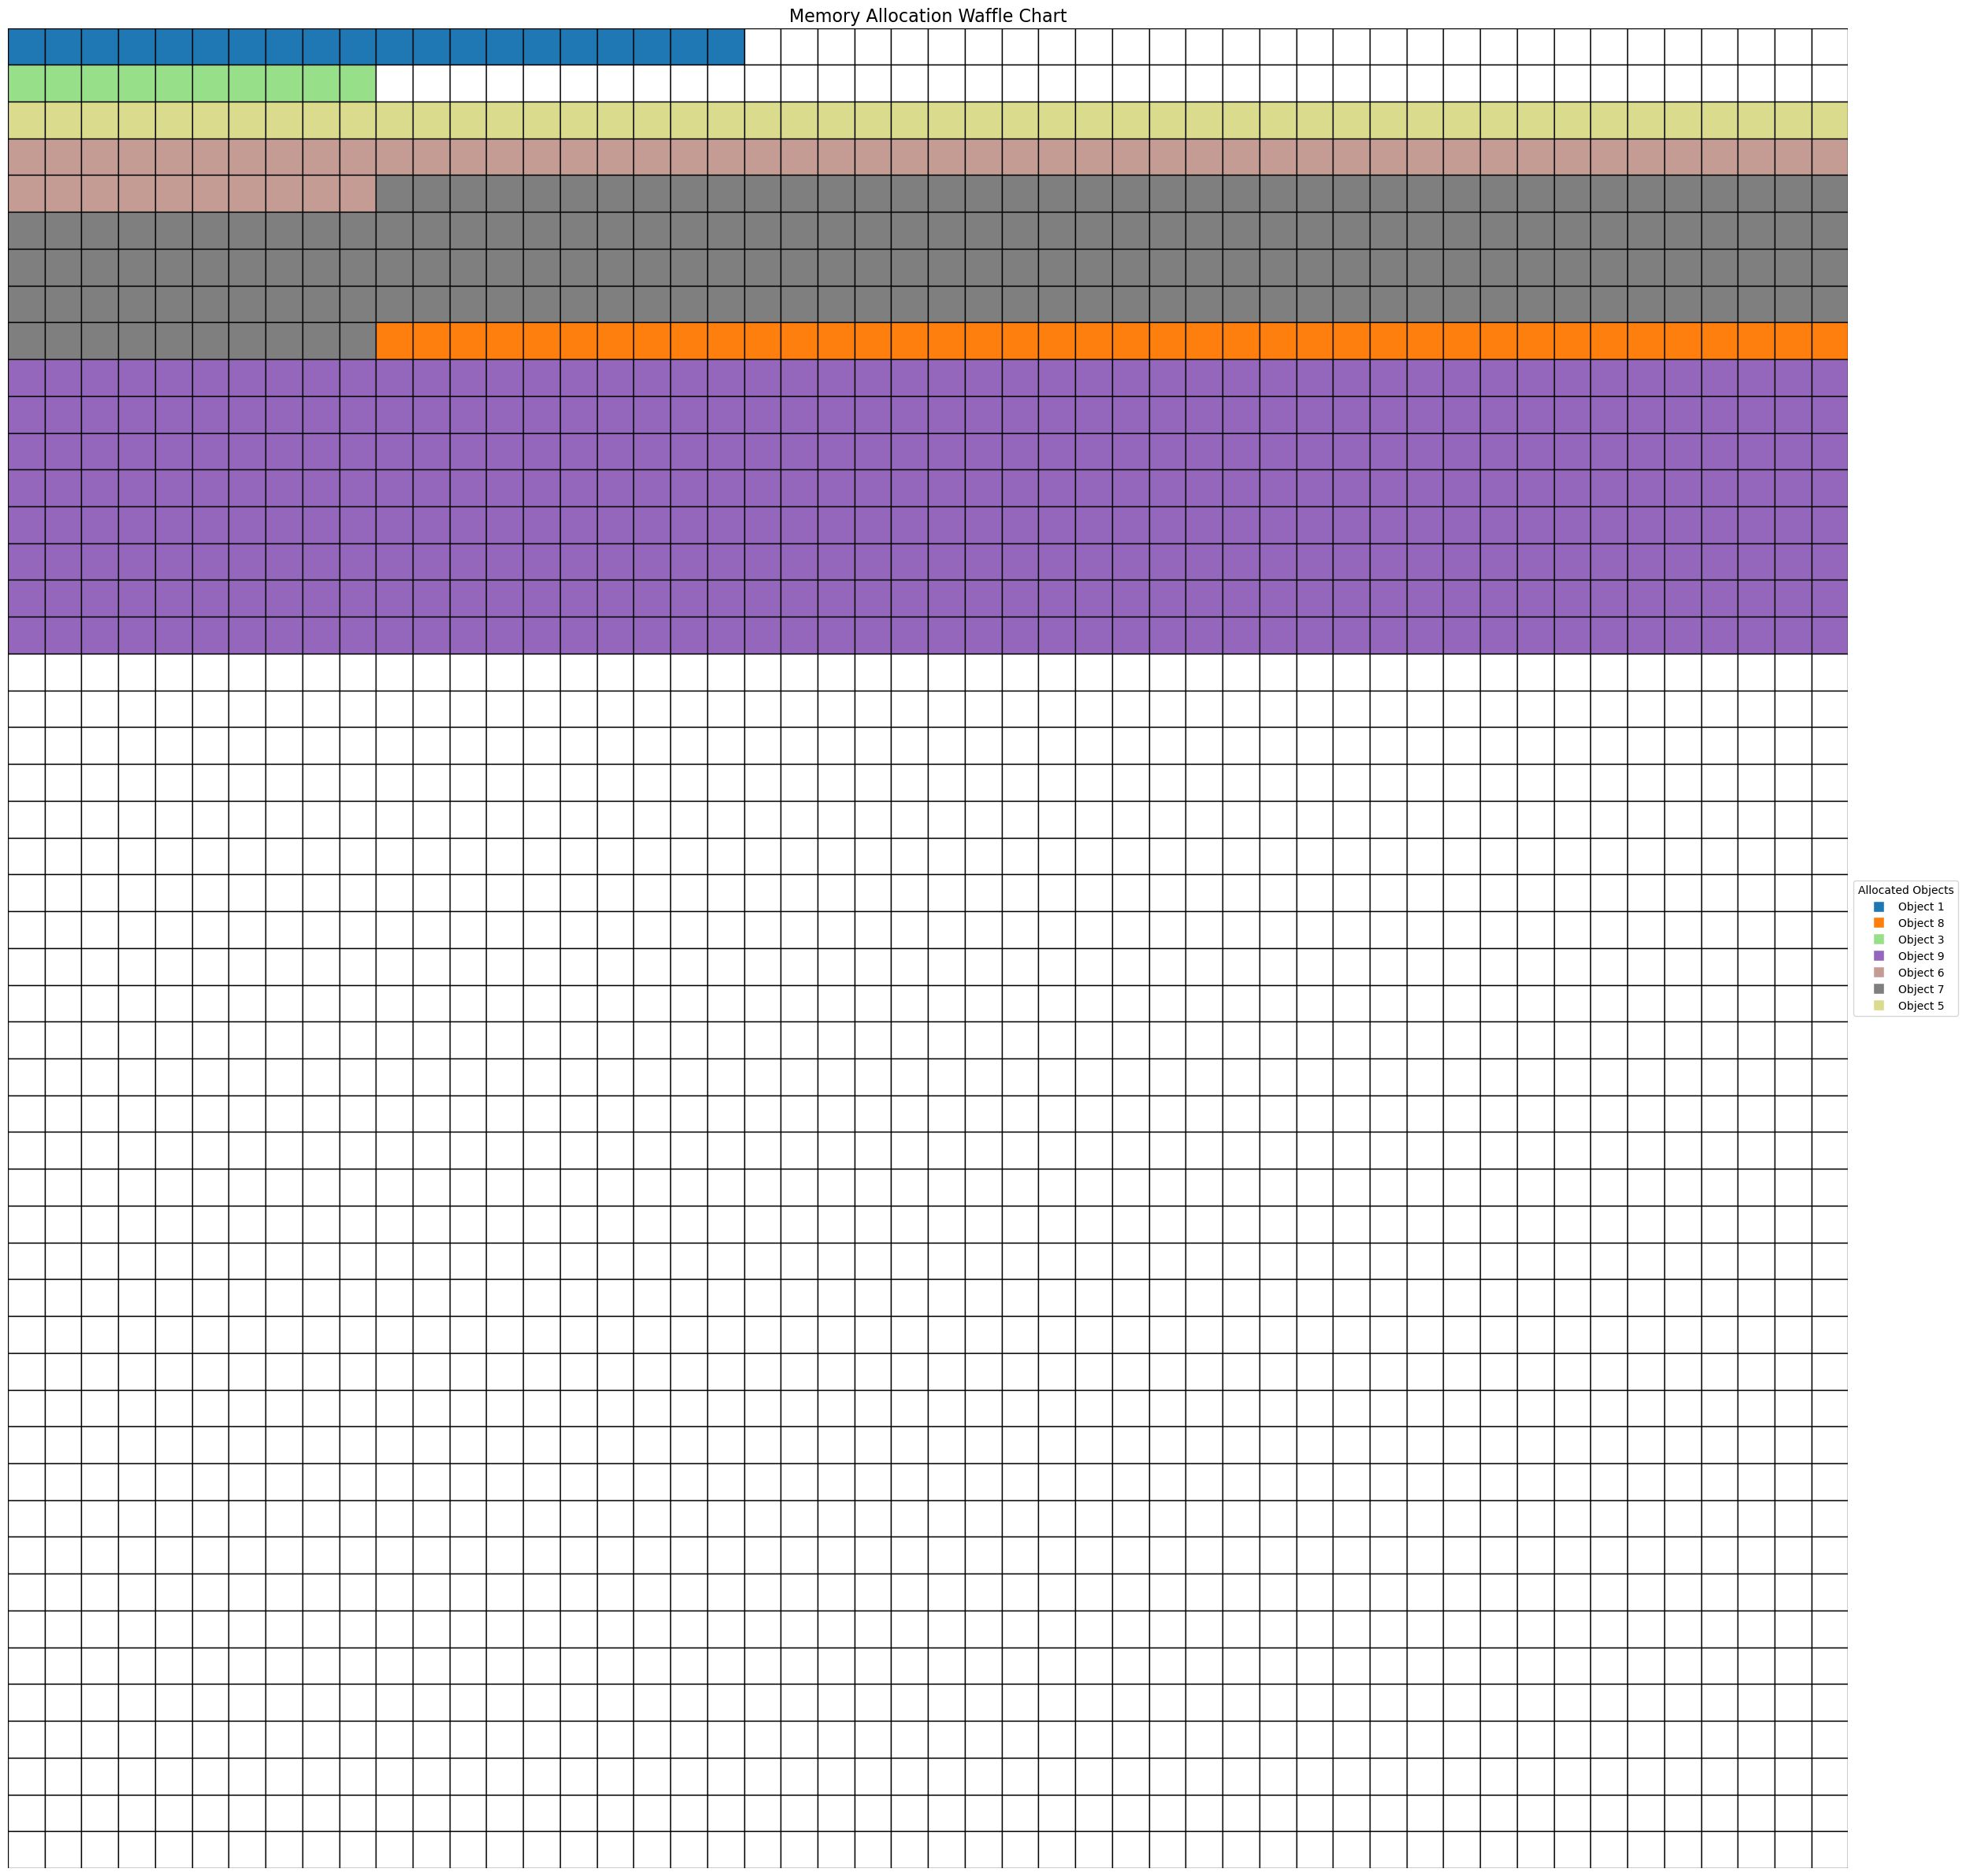

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_memory_waffle_scaled(memory, rows, cols):
    total_memory = len(memory)
    grid_size = rows * cols

    if total_memory > grid_size:
        raise ValueError("Grid size (rows * cols) is smaller than total memory size.")

    # 计算内存块在华夫图中的比例分布
    scaled_memory = []
    scale_factor = grid_size / total_memory
    for block in memory:
        block_count = int(round(scale_factor))  # 按比例放大或缩小
        scaled_memory.extend([block] * block_count)

    # 填充剩余的格子为空
    scaled_memory = scaled_memory[:grid_size] + [None] * (grid_size - len(scaled_memory))
    waffle_chart = np.array(scaled_memory).reshape((rows, cols))

    # 获取所有对象的颜色
    unique_objects = list(set(filter(None, waffle_chart.flatten())))
    object_colors = {obj: plt.cm.tab20(i / len(unique_objects))
                     for i, obj in enumerate(unique_objects)}

    # 绘制华夫饼图
    fig, ax = plt.subplots(figsize=(cols / 2, rows / 2))  # 根据行列动态调整图像大小
    for i in range(rows):
        for j in range(cols):
            block = waffle_chart[i, j]
            if block is None:
                color = 'white'  # 未占用区域
            else:
                color = object_colors[block]  # 分配对象颜色
            rect = plt.Rectangle((j, rows - i - 1), 1, 1, color=color, ec='black')
            ax.add_patch(rect)

    # 设置图形参数
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_aspect('equal')
    ax.axis('off')

    # 添加图例
    handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10)
               for color in object_colors.values()]
    labels = unique_objects
    ax.legend(handles, labels, loc="center left", bbox_to_anchor=(1, 0.5),
              title="Allocated Objects", fontsize=10)

    plt.title("Memory Allocation Waffle Chart", fontsize=16)
    plt.tight_layout()
    plt.show()

# 模拟内存分配和释放
def simulate_memory_allocation(total_memory, allocation_sizes, deallocation_indices):
    memory = [None] * total_memory  # 初始化内存块（None表示空闲，其他对象表示已占用）
    allocations = []  # 存储分配的位置

    current_position = 0
    for i, size in enumerate(allocation_sizes):
        # 寻找空闲位置
        while current_position + size <= total_memory:
            if all(block is None for block in memory[current_position:current_position + size]):
                # 使用对象标识分配的块
                object_id = f"Object {i + 1}"
                for j in range(current_position, current_position + size):
                    memory[j] = object_id
                allocations.append((current_position, size, object_id))
                break
            current_position += 1
        else:
            print(f"内存不足，无法分配大小为 {size} 的块")

    # 执行释放
    for index in deallocation_indices:
        if 0 <= index < len(allocations):
            start, size, _ = allocations[index]
            for i in range(start, start + size):
                memory[i] = None

    return memory

# 用户定义的网格大小和模拟内存分配
total_memory = 1000  # 总内存块数
allocation_sizes = [10, 15, 5, 20, 25,30,100,20,200]  # 每次分配的块大小
deallocation_indices = [1, 3]  # 释放块的索引
rows, cols = 50, 50  # 用户指定网格大小

memory = simulate_memory_allocation(total_memory, allocation_sizes, deallocation_indices)

# 绘制动态缩放的华夫饼图
visualize_memory_waffle_scaled(memory, rows, cols)


In [15]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_memory_waffle_scaled(memory, rows, cols):
    total_memory = len(memory)
    grid_size = rows * cols

    # 如果总内存超过网格大小，裁剪内存到可视化范围
    if total_memory > grid_size:
        print(f"Warning: Grid size ({grid_size}) is smaller than total memory ({total_memory}). Showing first {grid_size} blocks.")
        memory = memory[:grid_size]

    # 填充内存到网格大小（不足时填充None）
    scaled_memory = memory + [None] * (grid_size - len(memory))
    waffle_chart = np.array(scaled_memory).reshape((rows, cols))

    # 获取所有对象的颜色
    unique_objects = list(set(filter(None, waffle_chart.flatten())))
    object_colors = {obj: plt.cm.tab20(i / len(unique_objects))
                     for i, obj in enumerate(unique_objects)}

    # 绘制华夫饼图
    fig, ax = plt.subplots(figsize=(cols / 2, rows / 2))  # 根据行列动态调整图像大小
    for i in range(rows):
        for j in range(cols):
            block = waffle_chart[i, j]
            if block is None:
                color = 'white'  # 未占用区域
            else:
                color = object_colors[block]  # 分配对象颜色
            rect = plt.Rectangle((j, rows - i - 1), 1, 1, color=color, ec='black')
            ax.add_patch(rect)

    # 设置图形参数
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_aspect('equal')
    ax.axis('off')

    # 添加图例
    handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10)
               for color in object_colors.values()]
    labels = unique_objects
    ax.legend(handles, labels, loc="center left", bbox_to_anchor=(1, 0.5),
              title="Allocated Objects", fontsize=10)

    plt.title("Memory Allocation Waffle Chart", fontsize=16)
    plt.tight_layout()
    plt.show()

# 模拟内存分配和释放
def simulate_memory_allocation(total_memory, allocation_sizes, deallocation_indices):
    memory = [None] * total_memory  # 初始化内存块（None表示空闲，其他对象表示已占用）
    allocations = []  # 存储分配的位置

    current_position = 0
    for i, size in enumerate(allocation_sizes):
        # 寻找空闲位置
        while current_position + size <= total_memory:
            if all(block is None for block in memory[current_position:current_position + size]):
                # 使用对象标识分配的块
                object_id = f"Object {i + 1}"
                for j in range(current_position, current_position + size):
                    memory[j] = object_id
                allocations.append((current_position, size, object_id))
                break
            current_position += 1
        else:
            print(f"内存不足，无法分配大小为 {size} 的块")

    # 执行释放
    for index in deallocation_indices:
        if 0 <= index < len(allocations):
            start, size, _ = allocations[index]
            for i in range(start, start + size):
                memory[i] = None

    return memory

# 用户定义的网格大小和模拟内存分配
total_memory = 1000  # 总内存块数
allocation_sizes = [10, 15, 5, 20, 25]  # 每次分配的块大小
deallocation_indices = [1, 3]  # 释放块的索引
rows, cols = 200, 200  # 用户指定网格大小

memory = simulate_memory_allocation(total_memory, allocation_sizes, deallocation_indices)

# 绘制动态缩放的华夫饼图
visualize_memory_waffle_scaled(memory, rows, cols)
